In [1]:
# import lib
from __future__ import print_function
import numpy as np 
import math
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
%run 'Data Augmentation.ipynb'
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

Loading training set...
Done
Loading test set...
Done
Splitting into val/test set...
Done
Normalization...
Done
Converting to one-hot code...
Done
Generating images with Gaussian noise...
Done
Stacking Gaussian images...
Done
Finished!
number of training examples = 57472
number of validation examples = 9678
number of test examples = 9664
X_train shape: (57472, 100, 100, 3)
Y_train shape: (57472, 60)
X_val shape: (9678, 100, 100, 3)
Y_val shape: (9678, 60)
X_test shape: (9664, 100, 100, 3)
Y_test shape: (9664, 60)


In [4]:
# create placeholder for x and y
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    
    return X, Y

x, y = create_placeholders(100, 100, 3, 60)
print ("x = " + str(x))
print ("y = " + str(y))

x = Tensor("Placeholder:0", shape=(?, 100, 100, 3), dtype=float32)
y = Tensor("Placeholder_1:0", shape=(?, 60), dtype=float32)


In [5]:
# initialize parameters

def initialize_parameters():
    
    tf.set_random_seed(1)
    
    w1_shape = [3,3,3,16]
    w2_shape = [3,3,16,32]
    w3_shape = [3,3,32,32]
    w4_shape = [3,3,32,64]
    
    w1 = tf.get_variable('w1', w1_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w2 = tf.get_variable('w2', w2_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w3 = tf.get_variable('w3', w3_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    w4 = tf.get_variable('w4', w4_shape, initializer = tf.contrib.layers.xavier_initializer(seed=0))
    #b1 = tf.Variable(tf.zeros([16]), 'b1')
    #b2 = tf.Variable(tf.zeros([32]), 'b2')
    #b3 = tf.Variable(tf.zeros([32]), 'b3')
    #b4 = tf.Variable(tf.zeros([64]), 'b4')
    parameters = {'w1': w1, 'w2': w2, 'w3': w3, 'w4': w4}
    #parameters = {'w1': w1, 'w2': w2, 'w3': w3, 'w4': w4, 'b1': b1, 'b2': b2, 'b3': b3, 'b4': b4}
    
    return parameters

tf.reset_default_graph()
with tf.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.global_variables_initializer()
    sess_test.run(init)
    print('w1: ' + str(parameters['w1'].eval().shape))
    print('w2: ' + str(parameters['w2'].eval().shape))
    print('w3: ' + str(parameters['w3'].eval().shape))
    print('w4: ' + str(parameters['w4'].eval().shape))

In [13]:
# forward_propagation

def forward_propagation(x, parameters):
    # retrieve weights
    w1 = parameters['w1']
    w2 = parameters['w2']
    w3 = parameters['w3']
    w4 = parameters['w4']
    #b1 = parameters['b1']
    #b2 = parameters['b2']
    #b3 = parameters['b3']
    #b4 = parameters['b4']
    
    # conv1: k = (3,3), input = (100,100,3), output = 16, padding=0, stride =1
    z1 = tf.nn.conv2d(x, w1, strides = [1, 1, 1, 1], padding = 'SAME')
    #z1 = tf.nn.bias_add(z1, b1)
    # batchnormalization
    ba1 = tf.layers.batch_normalization(z1)
    # relu
    a1 = tf.nn.leaky_relu(ba1, alpha=0.5)
    # maxpool: (2,2), stride = 2, padding = 0
    p1 = tf.nn.max_pool(a1, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # dropout
    #d1 = tf.nn.dropout(p1, 0.5)
    
    # conv2: k = (3,3), input = 16, output = 32
    z2 = tf.nn.conv2d(p1, w2, strides = [1,1,1,1], padding = 'SAME')
    # z2 = tf.nn.bias_add(z2, b2)
    # batchnormalization
    ba2 = tf.layers.batch_normalization(z2)
    # relu
    a2 = tf.nn.leaky_relu(ba2, alpha=0.5)
    # maxpool: (2,2)
    p2 = tf.nn.max_pool(a2, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # dropout
    d2 = tf.nn.dropout(p2, 0.5)
    
    # conv3: k = (3,3), input = 32, output = 32
    z3 = tf.nn.conv2d(d2, w3, strides = [1,1,1,1], padding = 'SAME')
    #z3 = tf.nn.bias_add(z3, b3)
    # batchnormalization
    ba3 = tf.layers.batch_normalization(z3)
    # relu
    a3 = tf.nn.leaky_relu(ba3, alpha=0.5)
    # maxpool: (2,2)
    p3 = tf.nn.max_pool(a3, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    # dropout
    #d3 = tf.nn.dropout(p3, 0.5)
    
    # conv4: k = (3,3), input = 32, output = 64
    z4 = tf.nn.conv2d(p3, w4, strides = [1,1,1,1], padding = 'SAME')
    #z4 = tf.nn.bias_add(z4, b4)
    # batchnormalization
    ba4 = tf.layers.batch_normalization(z4)
    # relu
    a4 = tf.nn.leaky_relu(ba4, alpha=0.5)
    # maxpool: (2,2)
    p4 = tf.nn.max_pool(a4, ksize=[1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    
    
    # flatten
    p = tf.contrib.layers.flatten(p4)
    
    # fully-connected 
    # dense1
    h1 = tf.contrib.layers.fully_connected(p, 256, activation_fn = tf.nn.relu)
    # dropout
    d = tf.nn.dropout(h1, 0.5)
    
    # dense2
    y = tf.contrib.layers.fully_connected(d, 60, activation_fn = None)
    
    return y
    

tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    x, y = create_placeholders(100, 100, 3, 60)
    parameters = initialize_parameters()
    y_pred = forward_propagation(x, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(y_pred, {x: train_images[:10], y: train_labels[:10]})
    print(a.shape, a[0])

In [7]:
# compute cost
def compute_cost(y_pred, y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_pred, labels = y)) 
    return cost

def compute_accuracy(y_pred, x, y, size, x_, y_):
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(y_pred),1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    num = int(x_.shape[0]/size)
    acc_ = 0
    for i in range(num):
        acc = accuracy.eval({x:x_[i*size:(i+1)*size], y:y_[i*size:(i+1)*size]})
        acc_ += acc/num

    return acc_



tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    x, y = create_placeholders(100, 100, 3, 60)
    parameters = initialize_parameters()
    y_pred = forward_propagation(x, parameters)
    cost = compute_cost(y_pred, y)
    acc = compute_accuracy(y_pred, y)
    init = tf.global_variables_initializer()
    init2 = tf.local_variables_initializer()
    sess.run(init)
    sess.run(init2)
    a = sess.run([cost,acc], {x: train_images[:128], y: train_labels[:128]})
    print(a)

In [8]:
# training
def training(xtrain, ytrain, xtest, ytest, alpha = 0.001, epochs = 100, minibatch_size = 256, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    (m, n_H0, n_W0, n_C0) = xtrain.shape
    n_y = ytrain.shape[1]
    costs = []
    costs_test = []
    accs_train = []
    accs_test = []
    minibatch_num = int(m/minibatch_size)
    
    x,y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    
    # initialize
    parameters = initialize_parameters()
    
    # forwardprop
    y_pred = forward_propagation(x, parameters)
    y_softmax = tf.nn.softmax(y_pred)
    
    # cost function
    cost = compute_cost(y_pred, y)
    
    # backprop
    optimizer = tf.train.AdamOptimizer(alpha).minimize(cost)
       
    # initialize
    init = tf.global_variables_initializer()
    init2 = tf.local_variables_initializer()
    
     
    
    # session
    with tf.Session() as sess:
        sess.run(init)
        sess.run(init2)
            
        # training
        for epo in range(epochs):
            tf.set_random_seed(1)
            minibatch_cost = 0
            cost_test = 0
            
            # shuffle
            minibatch = np.random.choice(np.random.permutation(m), 
                                         minibatch_size * minibatch_num).reshape(minibatch_num, minibatch_size)
            minibatch_index = np.random.permutation(minibatch_num)  
                       
            for mb in range(minibatch_num):
                i = minibatch_index[mb]
                indx = minibatch[i]
                inputs = xtrain[indx]
                labels = ytrain[indx]

                # feed the inputs
                _, temp_cost = sess.run([optimizer, cost], feed_dict={x: inputs, y: labels})
                
                # calculate average cost after 1 epoch
                minibatch_cost += temp_cost / minibatch_num
            
            
            # calculate cost of test set after 1 epoch
            for i in range(10):
                temp_test = sess.run(cost, feed_dict={x:xtest[i*967:(i+1)*967], y:ytest[i*967:(i+1)*967]})
                cost_test += temp_test / 10

            
            # add cost of this epoch to the lists
            costs.append(minibatch_cost)
            costs_test.append(cost_test)
            
            acc_train = compute_accuracy(y_softmax, x, y, 967, xtrain, ytrain) * 100
            accs_train.append(acc_train)
            acc_test = compute_accuracy(y_softmax, x, y, 967, xtest, ytest) * 100
            accs_test.append(acc_test)
            
            # print result
            if print_cost == True and epo % 5 == 4:
                print('Cost after epoch %i: %f' %(epo+1, minibatch_cost))
                print('Cross Validation cost after epoch %i: %f' %(epo+1, cost_test))
                
                print('Training accuracy after epoch %i: %.3f %%' %(epo+1, acc_train))

                print('Testing accuracy after epoch %i: %.3f %%' %(epo+1, acc_test))
        
                    
        # plot cost
        plt.plot(np.squeeze(costs), label = 'train')
        plt.plot(np.squeeze(costs_test), label = 'validation')
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()
        
        # plot accuracy
        plt.plot(np.squeeze(accs_train), label = 'train')
        plt.plot(np.squeeze(accs_test), label = 'validation')
        plt.ylabel('accuracy(%)')
        plt.xlabel('epochs')
        plt.legend()
        plt.show()       
        
        
        return parameters

Cost after epoch 5: 0.058194
Cross Validation cost after epoch 5: 0.285058
Training accuracy after epoch 5: 97.988 %
Testing accuracy after epoch 5: 92.888 %
Cost after epoch 10: 0.035220
Cross Validation cost after epoch 10: 0.282986
Training accuracy after epoch 10: 98.891 %
Testing accuracy after epoch 10: 93.968 %
Cost after epoch 15: 0.032124
Cross Validation cost after epoch 15: 0.318309
Training accuracy after epoch 15: 99.015 %
Testing accuracy after epoch 15: 93.841 %
Cost after epoch 20: 0.015343
Cross Validation cost after epoch 20: 0.269161
Training accuracy after epoch 20: 99.613 %
Testing accuracy after epoch 20: 95.519 %
Cost after epoch 25: 0.022790
Cross Validation cost after epoch 25: 0.242156
Training accuracy after epoch 25: 99.656 %
Testing accuracy after epoch 25: 95.599 %
Cost after epoch 30: 0.014085
Cross Validation cost after epoch 30: 0.213514
Training accuracy after epoch 30: 99.725 %
Testing accuracy after epoch 30: 96.300 %
Cost after epoch 35: 0.013424
Cr

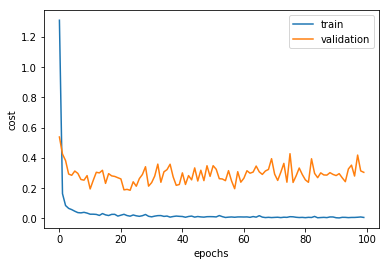

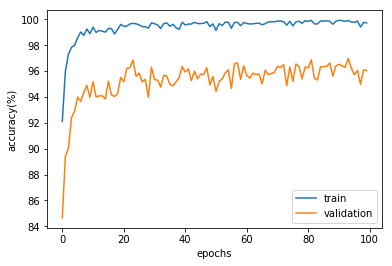

In [14]:
parameters = training(X_train, Y_train, X_test, Y_test)